In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import pathlib
import matplotlib.image as mpimg
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Sequential
import datetime

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-04-01 18:27:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-01 18:27:34 (81.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-04-01 18:27:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   228MB/s    in 7.6s    

2023-04-01 18:27:43 (203 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
unzip_data("/content/101_food_classes_10_percent.zip")

In [5]:
train_dir = "/content/101_food_classes_10_percent/train"
test_dir = "/content/101_food_classes_10_percent/test"

In [6]:
IMAGE_SIZE = (224, 224)
INPUT_SIZE = (224, 224, 3)

In [7]:
train_data = image_dataset_from_directory(train_dir,
                                          label_mode = "categorical",
                                          batch_size = 32,
                                          image_size = IMAGE_SIZE)

test_data = image_dataset_from_directory(test_dir,
                                         label_mode = "categorical",
                                         batch_size = 32,
                                         image_size = IMAGE_SIZE,
                                         shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model1_checkpoint",
                                                      save_weights_only=True,
                                                      save_best_only=True ,
                                                      monitor="val_accuracy")

In [9]:
data_aug_model = Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip("horizontal"),
], name = "data_augmentation")

In [10]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [11]:
inputs = Input(shape = INPUT_SIZE)
x = data_aug_model(inputs, training = True)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = Dense(101, activation = "softmax")(x)

model1 = tf.keras.Model(inputs, outputs)

model1.compile(loss = categorical_crossentropy,
               optimizer = Adam(),
               metrics = ["accuracy"])

In [12]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [13]:
history1 = model1.fit(train_data,
                      epochs = 5,
                      steps_per_epoch = len(train_data),
                      validation_data = test_data,
                      validation_steps = int(0.15*len(test_data)),
                      callbacks = [model_checkpoint])

Epoch 1/5
237/237 [==============================] - 138s 515ms/step - loss: 3.3668 - accuracy: 0.2795 - val_loss: 2.6733 - val_accuracy: 0.4041
Epoch 2/5
237/237 [==============================] - 84s 351ms/step - loss: 2.2136 - accuracy: 0.4933 - val_loss: 2.2098 - val_accuracy: 0.4740
Epoch 3/5
237/237 [==============================] - 94s 392ms/step - loss: 1.8230 - accuracy: 0.5665 - val_loss: 2.0726 - val_accuracy: 0.4860
Epoch 4/5
237/237 [==============================] - 68s 285ms/step - loss: 1.5990 - accuracy: 0.6170 - val_loss: 2.0357 - val_accuracy: 0.4910
Epoch 5/5
237/237 [==============================] - 61s 258ms/step - loss: 1.4620 - accuracy: 0.6395 - val_loss: 1.9599 - val_accuracy: 0.4942


In [14]:
model1.evaluate(test_data)

790/790 [==============================] - 117s 149ms/step - loss: 1.7718 - accuracy: 0.5441


[1.771813988685608, 0.5441188216209412]

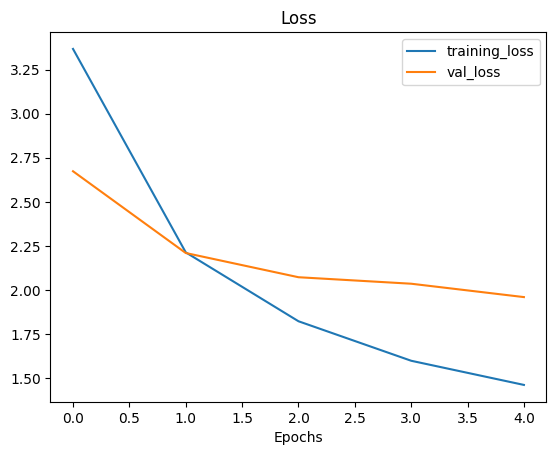

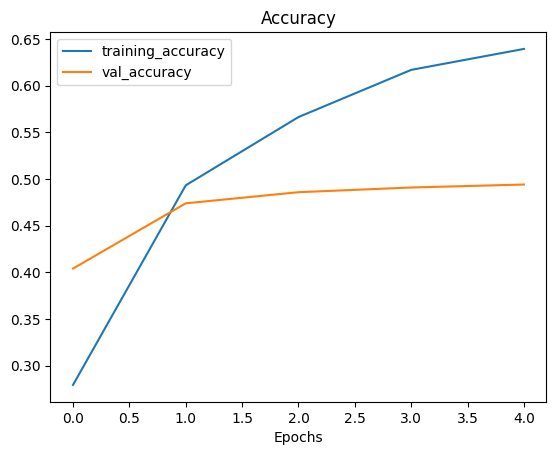

In [15]:
plot_loss_curves(history1)

In [16]:
base_model.trainable = True
for i, layer in enumerate(model1.layers):
  print(i, layer.name, layer.trainable)

for layer in base_model.layers[:-5]:
  layer.trainable = False

for i, layer in enumerate(model1.layers):
  print(i, layer.name, layer.trainable)

for i, layer in enumerate(model1.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_2 True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling2d True
4 dense True
0 input_2 True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling2d True
4 dense True
0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 bloc

In [17]:
model1.compile(loss = categorical_crossentropy,
               optimizer = Adam(learning_rate = 0.0001),
               metrics = ["accuracy"])
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 910,821
Non-trainab

In [18]:
for i, layer in enumerate(model1.layers):
  print(i, layer.name, layer.trainable)

0 input_2 True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling2d True
4 dense True


In [19]:
history2 = model1.fit(train_data, 
           epochs = 10,
           initial_epoch=history1.epoch[-1],
           validation_data = test_data,
           validation_steps = int(0.15*len(test_data)),
           callbacks = [tf.keras.callbacks.ModelCheckpoint("model1_checkpoint2",
                                                      save_weights_only=True,
                                                      save_best_only=True ,
                                                      monitor="val_accuracy")])

Epoch 5/10
237/237 [==============================] - 68s 246ms/step - loss: 1.2173 - accuracy: 0.6838 - val_loss: 1.8875 - val_accuracy: 0.5085
Epoch 6/10
237/237 [==============================] - 47s 197ms/step - loss: 1.0993 - accuracy: 0.7055 - val_loss: 1.9406 - val_accuracy: 0.4968
Epoch 7/10
237/237 [==============================] - 53s 224ms/step - loss: 1.0156 - accuracy: 0.7261 - val_loss: 1.9133 - val_accuracy: 0.5090
Epoch 8/10
237/237 [==============================] - 44s 185ms/step - loss: 0.9503 - accuracy: 0.7446 - val_loss: 1.8486 - val_accuracy: 0.5299
Epoch 9/10
237/237 [==============================] - 45s 189ms/step - loss: 0.8948 - accuracy: 0.7595 - val_loss: 1.8733 - val_accuracy: 0.5130
Epoch 10/10
237/237 [==============================] - 42s 174ms/step - loss: 0.8339 - accuracy: 0.7799 - val_loss: 1.9021 - val_accuracy: 0.5130


In [20]:
model1.evaluate(test_data)

790/790 [==============================] - 84s 106ms/step - loss: 1.6508 - accuracy: 0.5749


[1.6507669687271118, 0.5749306678771973]

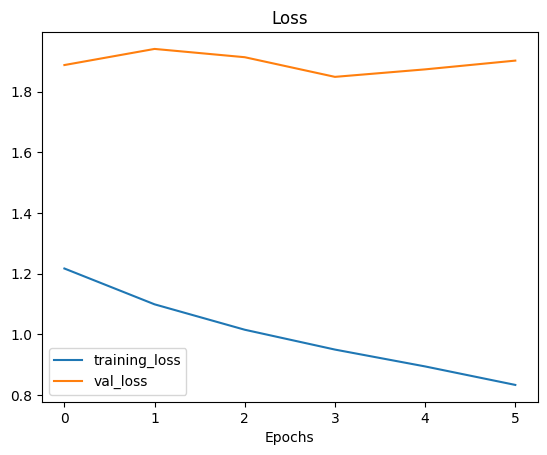

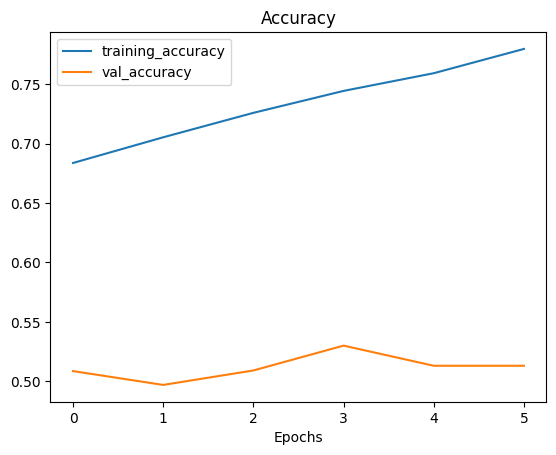

In [21]:
plot_loss_curves(history2)

In [ ]:
# model1.save("saved_model") #saved to drive

In [ ]:
# loaded_model = tf.keras.models.load_model("saved_model")

In [24]:
pred_probs = model1.predict(test_data, verbose = 1)

790/790 [==============================] - 80s 97ms/step


In [ ]:
pred_probs[0]

In [27]:
pred_classes = pred_probs.argmax(axis=1)

In [28]:
test_data.unbatch()

<_UnbatchDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(101,), dtype=tf.float32, name=None))>

In [31]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [32]:
from sklearn.metrics import accuracy_score

sklearn_acuuracy = accuracy_score(y_labels, pred_classes)
sklearn_acuuracy

0.5738613861386138

In [33]:
from helper_functions import make_confusion_matrix

class_names = test_data.class_names

make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.26      0.18      0.21       250
           1       0.65      0.52      0.58       250
           2       0.59      0.57      0.58       250
           3       0.60      0.62      0.61       250
           4       0.43      0.45      0.44       250
           5       0.50      0.42      0.45       250
           6       0.76      0.73      0.75       250
           7       0.78      0.76      0.77       250
           8       0.30      0.41      0.35       250
           9       0.50      0.43      0.46       250
          10       0.41      0.46      0.43       250
          11       0.61      0.64      0.62       250
          12       0.65      0.54      0.59       250
          13       0.51      0.53      0.52       250
          14       0.44      0.54      0.48       250
          15       0.33      0.41      0.37       250
          16       0.49      0.57      0.53       250
          17       0.42    

In [35]:
class_dict = classification_report(y_true = y_labels, y_pred=pred_classes, output_dict=True)
class_dict

{'0': {'precision': 0.2556818181818182,
  'recall': 0.18,
  'f1-score': 0.2112676056338028,
  'support': 250},
 '1': {'precision': 0.6467661691542289,
  'recall': 0.52,
  'f1-score': 0.5764966740576497,
  'support': 250},
 '2': {'precision': 0.5867768595041323,
  'recall': 0.568,
  'f1-score': 0.5772357723577235,
  'support': 250},
 '3': {'precision': 0.6015625,
  'recall': 0.616,
  'f1-score': 0.608695652173913,
  'support': 250},
 '4': {'precision': 0.42641509433962266,
  'recall': 0.452,
  'f1-score': 0.4388349514563107,
  'support': 250},
 '5': {'precision': 0.49523809523809526,
  'recall': 0.416,
  'f1-score': 0.4521739130434783,
  'support': 250},
 '6': {'precision': 0.7593360995850622,
  'recall': 0.732,
  'f1-score': 0.745417515274949,
  'support': 250},
 '7': {'precision': 0.7755102040816326,
  'recall': 0.76,
  'f1-score': 0.7676767676767676,
  'support': 250},
 '8': {'precision': 0.29941860465116277,
  'recall': 0.412,
  'f1-score': 0.3468013468013468,
  'support': 250},
 '9

In [37]:
class_f1_scores = {}

for key, value in class_dict.items():
  if key == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(key)]] = value["f1-score"]

class_f1_scores

{'apple_pie': 0.2112676056338028,
 'baby_back_ribs': 0.5764966740576497,
 'baklava': 0.5772357723577235,
 'beef_carpaccio': 0.608695652173913,
 'beef_tartare': 0.4388349514563107,
 'beet_salad': 0.4521739130434783,
 'beignets': 0.745417515274949,
 'bibimbap': 0.7676767676767676,
 'bread_pudding': 0.3468013468013468,
 'breakfast_burrito': 0.46021505376344085,
 'bruschetta': 0.430188679245283,
 'caesar_salad': 0.6235294117647059,
 'cannoli': 0.5864332603938731,
 'caprese_salad': 0.5185185185185185,
 'carrot_cake': 0.4821428571428571,
 'ceviche': 0.36756756756756753,
 'cheese_plate': 0.5288640595903166,
 'cheesecake': 0.3991596638655462,
 'chicken_curry': 0.4636363636363636,
 'chicken_quesadilla': 0.5813008130081301,
 'chicken_wings': 0.6549707602339182,
 'chocolate_cake': 0.463768115942029,
 'chocolate_mousse': 0.32372505543237245,
 'churros': 0.6929460580912864,
 'clam_chowder': 0.6653386454183267,
 'club_sandwich': 0.7071583514099783,
 'crab_cakes': 0.4031936127744511,
 'creme_brulee':

In [42]:
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "f1_scores":list(class_f1_scores.values())}).sort_values("f1_scores", ascending = False)

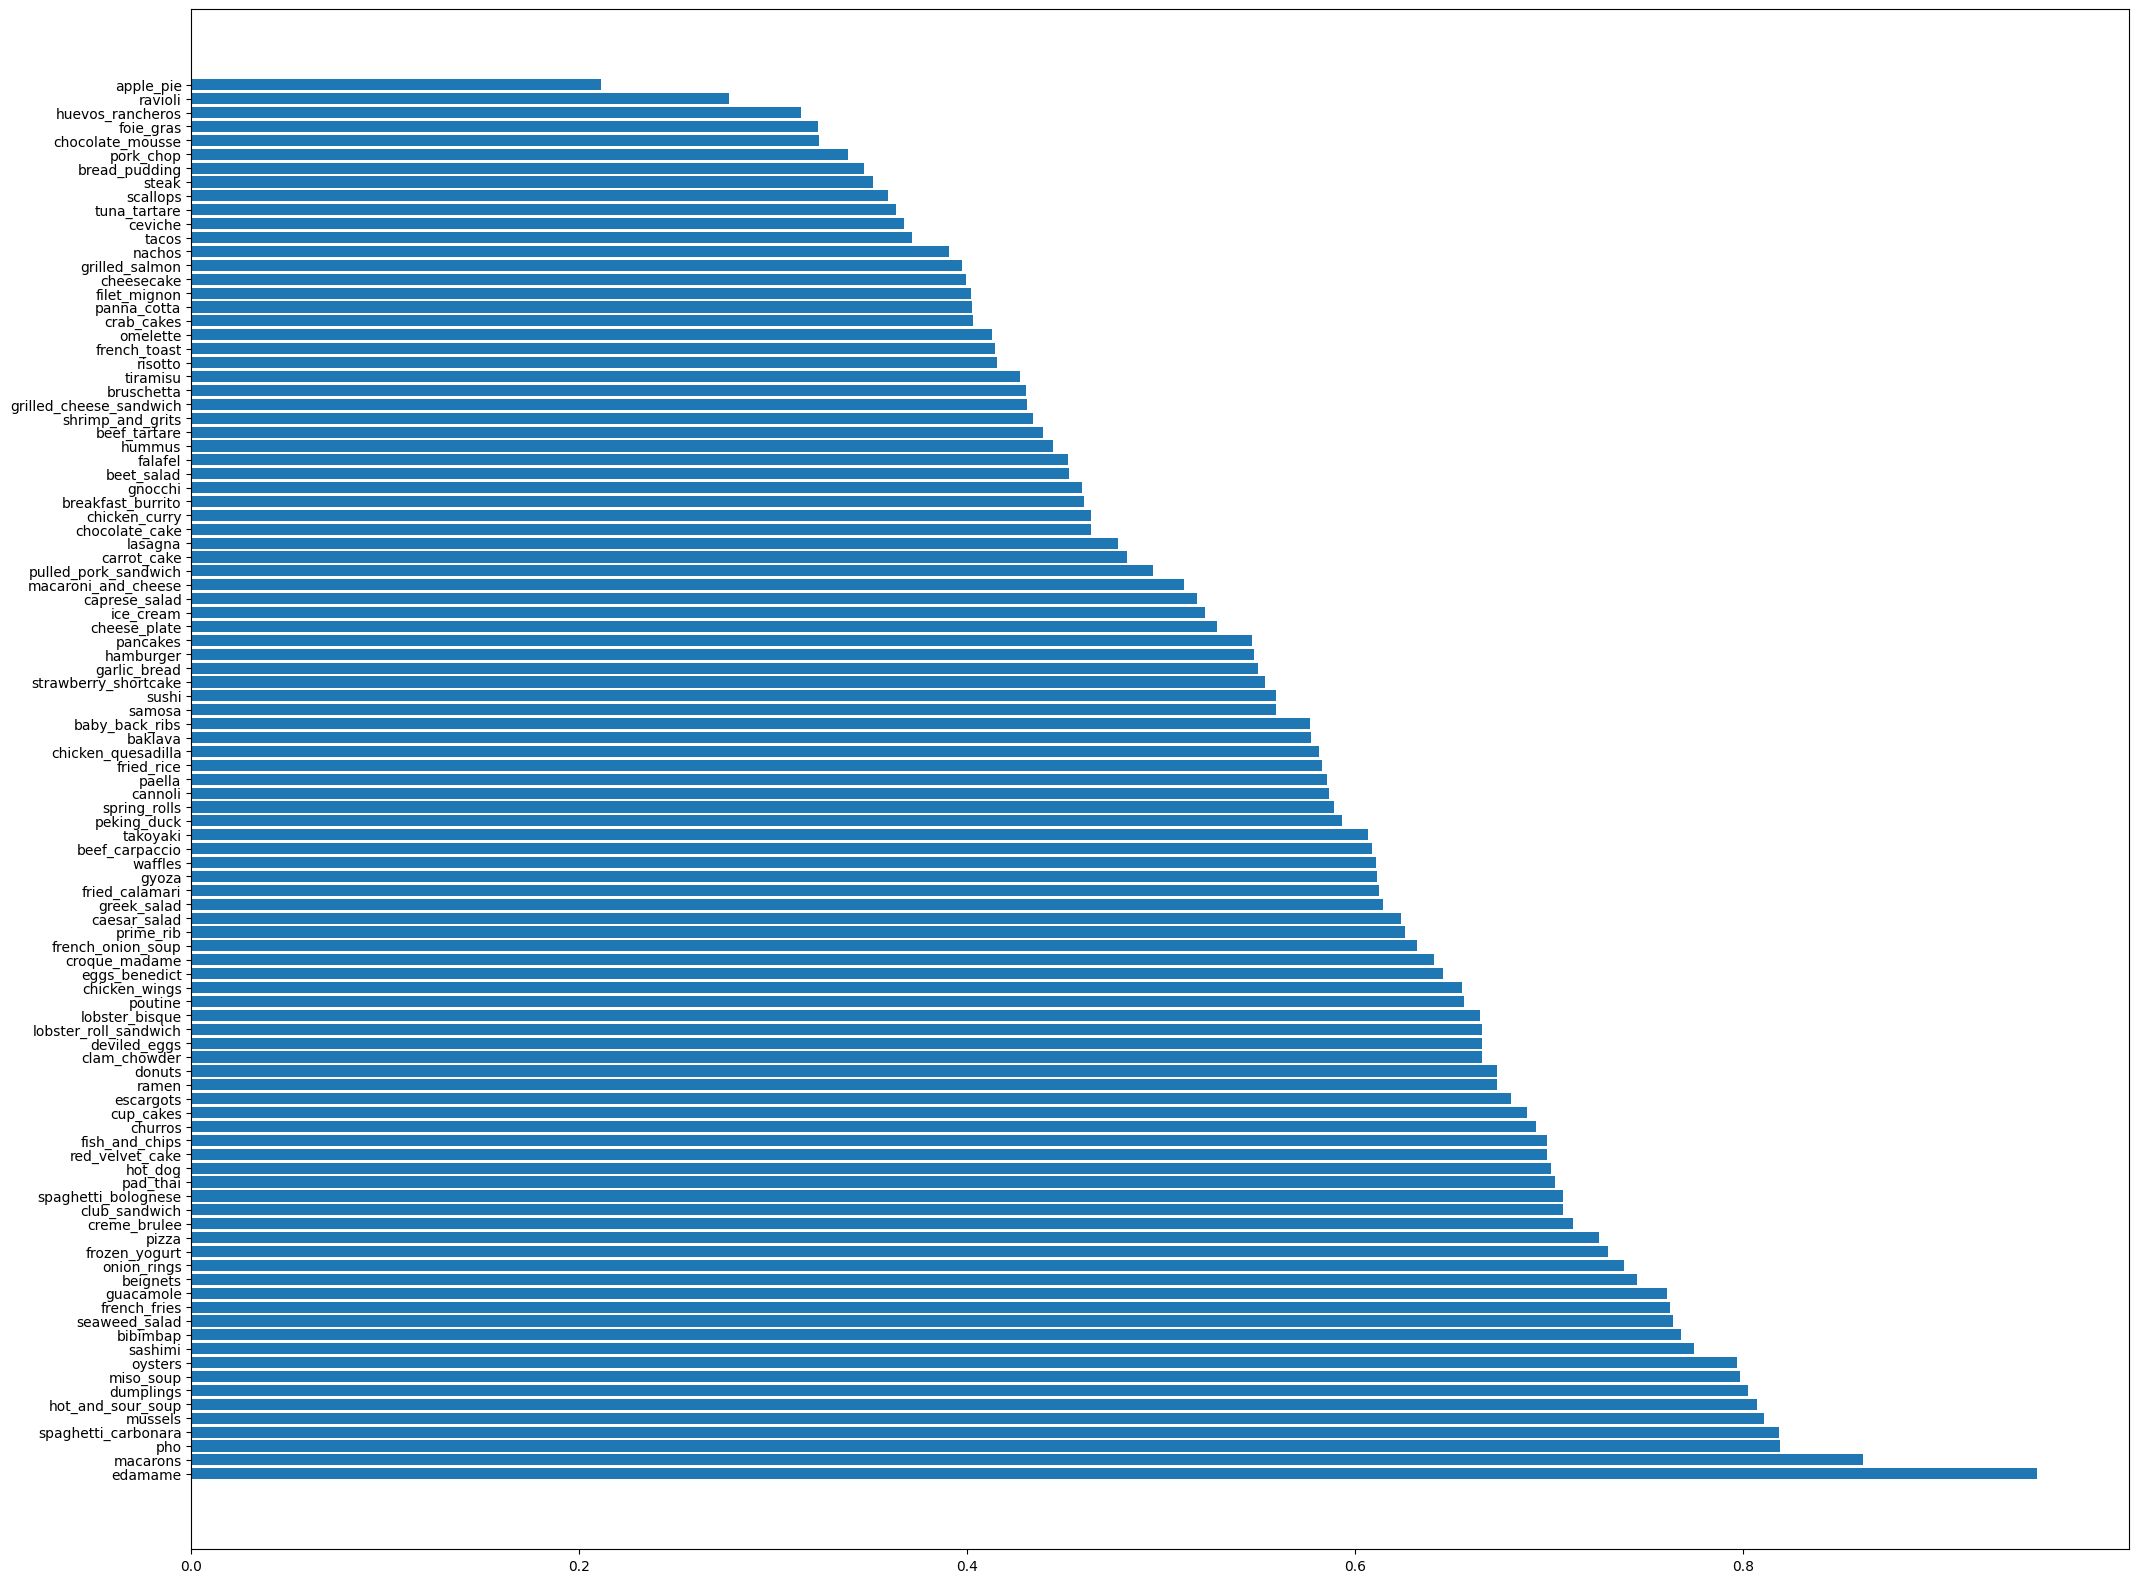

In [51]:
fig, ax = plt.subplots(figsize =(25, 20))
ax.barh(f1_scores["class_names"], f1_scores["f1_scores"])
plt.show()